In [2]:
import os
import time
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils
#from torchsummary import summary
from sklearn.metrics import accuracy_score, confusion_matrix

from PIL import Image




In [3]:
writer = SummaryWriter('runs/fashion-mnist-1')

# 1.Load CSV Files

In [11]:
data_path = os.path.join("storage", "data", "fashion-mnist")
train_path = os.path.join(data_path, "fashion-mnist_train.csv")
test_path = os.path.join(data_path, "fashion-mnist_test.csv")
print(train_path, test_path)

storage\data\fashion-mnist\fashion-mnist_train.csv storage\data\fashion-mnist\fashion-mnist_test.csv


In [12]:
train_df = pd.read_csv(train_path)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [13]:
test_df = pd.read_csv(test_path)
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [14]:
print(train_df.shape, test_df.shape)
print(train_df.info())
print(test_df.info())

(60000, 785) (10000, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB
None


In [15]:
train_df.iloc[0, 1:].max()

255

In [16]:
train_df['label'].value_counts()

label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64

In [17]:
test_df['label'].value_counts()

label
0    1000
1    1000
2    1000
3    1000
8    1000
6    1000
5    1000
4    1000
7    1000
9    1000
Name: count, dtype: int64

# 2.Format into images

In [18]:
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")
print(train_path, test_path)

storage\data\fashion-mnist\train storage\data\fashion-mnist\test


In [19]:
for path in [train_path, test_path]:
    if not os.path.exists(path):
        os.mkdir(path)

In [20]:
class_labels = train_df['label'].unique().tolist()
print(class_labels)

[2, 9, 6, 0, 3, 4, 5, 8, 7, 1]


In [23]:
for path in [train_path, test_path]:
    for class_label in class_labels:
        class_path = os.path.join(path, str(class_label))
        if not os.path.exists(class_path):
            os.mkdir(class_path)

In [24]:
for row_id, row in tqdm(train_df.iterrows(), total=len(train_df)):
    label = row['label']
    image_path = os.path.join(train_path, str(label), f'{row_id}.png')
    pixels = row.iloc[1:].values.astype('uint8')
    pixels = pixels.reshape(28,28)
    image = Image.fromarray(pixels)
    image.save(image_path)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [25]:
for row_id, row in tqdm(test_df.iterrows(), total=len(test_df)):
    label = row['label']
    image_path = os.path.join(test_path, str(label), f'{row_id}.png')
    pixels = row.iloc[1:].values.astype('uint8')
    pixels = pixels.reshape(28,28)
    image = Image.fromarray(pixels)
    image.save(image_path)

  0%|          | 0/10000 [00:00<?, ?it/s]

# 3.Define Dataset

In [4]:
train_path = os.path.join("storage", "data", "fashion-mnist", "train")
test_path = os.path.join("storage", "data", "fashion-mnist", "test")
print(train_path, test_path)

storage\data\fashion-mnist\train storage\data\fashion-mnist\test


In [5]:
mean = 0.5
sd = 0.5
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (sd, ))
])

In [6]:
train_set = datasets.ImageFolder(root=train_path, transform=transform)
test_set = datasets.ImageFolder(root=test_path, transform=transform)

# 4.Define DataLoader

In [7]:
train_batch_size = 64
test_batch_size = 4

In [8]:
num_cpus = os.cpu_count()
print(num_cpus)

8


In [9]:
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_cpus)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=num_cpus)

In [10]:
len_train_loader = len(train_loader)
print(len_train_loader)

938


# 5.Utilities

In [11]:
label_to_name = {
    '0': 't-shirt',
    '1': 'trouser',
    '2': 'pullover',
    '3': 'dress',
    '4': 'coat',
    '5': 'sandal',
    '6': 'shirt',
    '7': 'sneaker',
    '8': 'bag',
    '9': 'ankle_boot'
}

In [12]:
name_to_label = {v:k for k,v in label_to_name.items()}
print(name_to_label)

{'t-shirt': '0', 'trouser': '1', 'pullover': '2', 'dress': '3', 'coat': '4', 'sandal': '5', 'shirt': '6', 'sneaker': '7', 'bag': '8', 'ankle_boot': '9'}


In [13]:
def plot_image(image_tensor, title=""):
    image_tensor = image_tensor.mean(dim=0)
    image_tensor = (image_tensor * sd) + mean
    image_tensor = image_tensor * 255
    image_array = image_tensor.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(image_array, cmap='Greys')
    plt.title(title)
    return plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

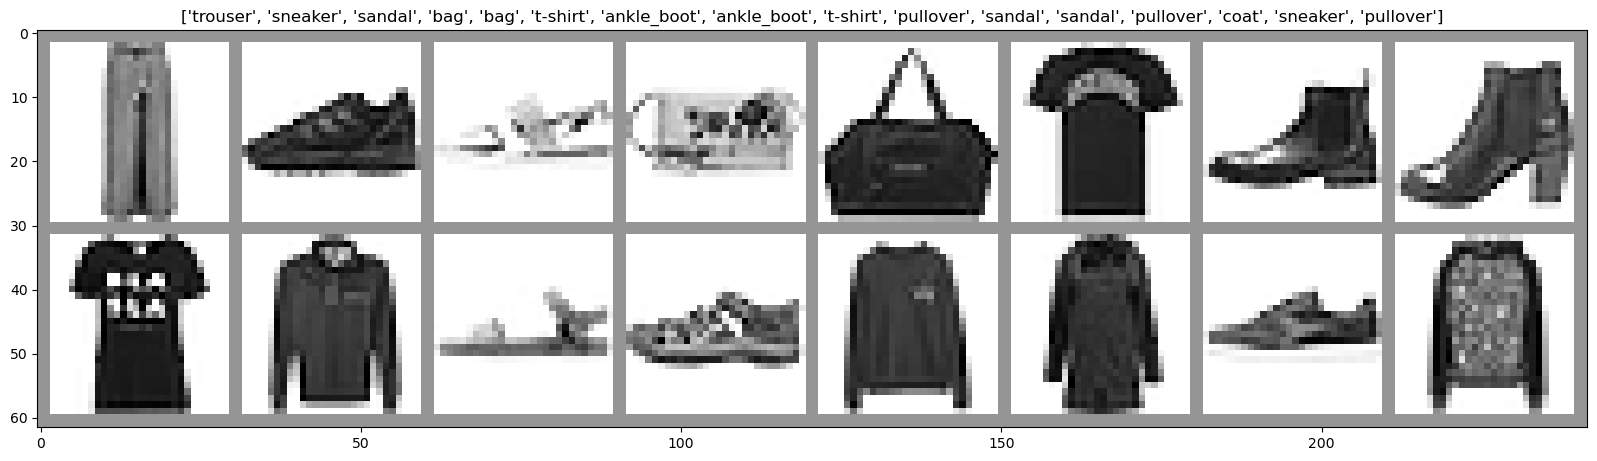

In [15]:
train_iter = iter(train_loader)
X, Y = train_iter.__next__()
m = min(16, len(train_loader))
image_grid = utils.make_grid(X[:m])
names = [label_to_name[str(label.item())] for label in Y[:m]]
plot_image(image_grid, title=names)

# 6. Define Model

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0) # [m,6,24,24]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # [m,6,12,12]
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0) # [m,16,8,8]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # [m,16,4,4]
        self.fc3 = nn.Linear(in_features=16*4*4, out_features=120) # [m,120]
        self.fc4 = nn.Linear(in_features=120, out_features=84) # [m,84]
        self.fc5 = nn.Linear(in_features=84, out_features=10) # [m,10]

    def forward(self, X):
        X = self.pool1(F.relu(self.conv1(X)))
        X = self.pool2(F.relu(self.conv2(X)))
        X = X.view(-1, 16*4*4)
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        return X
    

In [18]:
model = Model()
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): Model(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc3): Linear(in_features=256, out_features=120, bias=True)
    (fc4): Linear(in_features=120, out_features=84, bias=True)
    (fc5): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [19]:
# summary(model, input_size(1,28,28))

In [20]:
writer.add_graph(model, X)
writer.close()

# 7.Set Optimizer

In [21]:
lr = 0.001
step_size = len_train_loader * 4    
gamma = 0.95
print(step_size)

3752


In [22]:
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=gamma, step_size=step_size)

# 8.Train Model

In [23]:
epochs = 20
print_every_n_epochs = 1

In [24]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1)):
    epoch_loss = 0
    epoch_lr = 0

    for X, Y in tqdm(train_loader, desc=f'Epoch-{epoch}'):
        X,Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]

    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)

    if epoch % print_every_n_epochs == 0:
        message = f'Epoch:{epoch}    Loss:{epoch_loss}    LR:{epoch_lr}'
        print(message)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch-1:   0%|          | 0/938 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\Dekalog\Lib\site-packages\torch\optim\lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch:1    Loss:0.650729079728823    LR:0.0010000000000000007


Epoch-2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:2    Loss:0.4068097517148518    LR:0.0010000000000000007


Epoch-3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:3    Loss:0.34493955902294565    LR:0.0010000000000000007


Epoch-4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:4    Loss:0.3144957936966597    LR:0.000999896055437101


Epoch-5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:5    Loss:0.28696690548235165    LR:0.000950000000000006


Epoch-6:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:6    Loss:0.26981299633442213    LR:0.000950000000000006


Epoch-7:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:7    Loss:0.2560666093964185    LR:0.000950000000000006


Epoch-8:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:8    Loss:0.24108015105668415    LR:0.0009499012526652512


Epoch-9:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:9    Loss:0.23043223690471923    LR:0.0009025000000000037


Epoch-10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:10    Loss:0.21815336822097237    LR:0.0009025000000000037


Epoch-11:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:11    Loss:0.20925038405207555    LR:0.0009025000000000037


Epoch-12:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:12    Loss:0.2025909005864851    LR:0.0009024061900319866


Epoch-13:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:13    Loss:0.19275548158169808    LR:0.0008573750000000151


Epoch-14:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:14    Loss:0.1839918587555382    LR:0.0008573750000000151


Epoch-15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:15    Loss:0.17698258878405032    LR:0.0008573750000000151


Epoch-16:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:16    Loss:0.17242222934611826    LR:0.0008572858805303989


Epoch-17:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:17    Loss:0.16193581197553797    LR:0.000814506250000011


Epoch-18:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:18    Loss:0.15663984588690913    LR:0.000814506250000011


Epoch-19:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:19    Loss:0.15206865636683475    LR:0.000814506250000011


Epoch-20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch:20    Loss:0.14489414842167833    LR:0.0008144215865038757


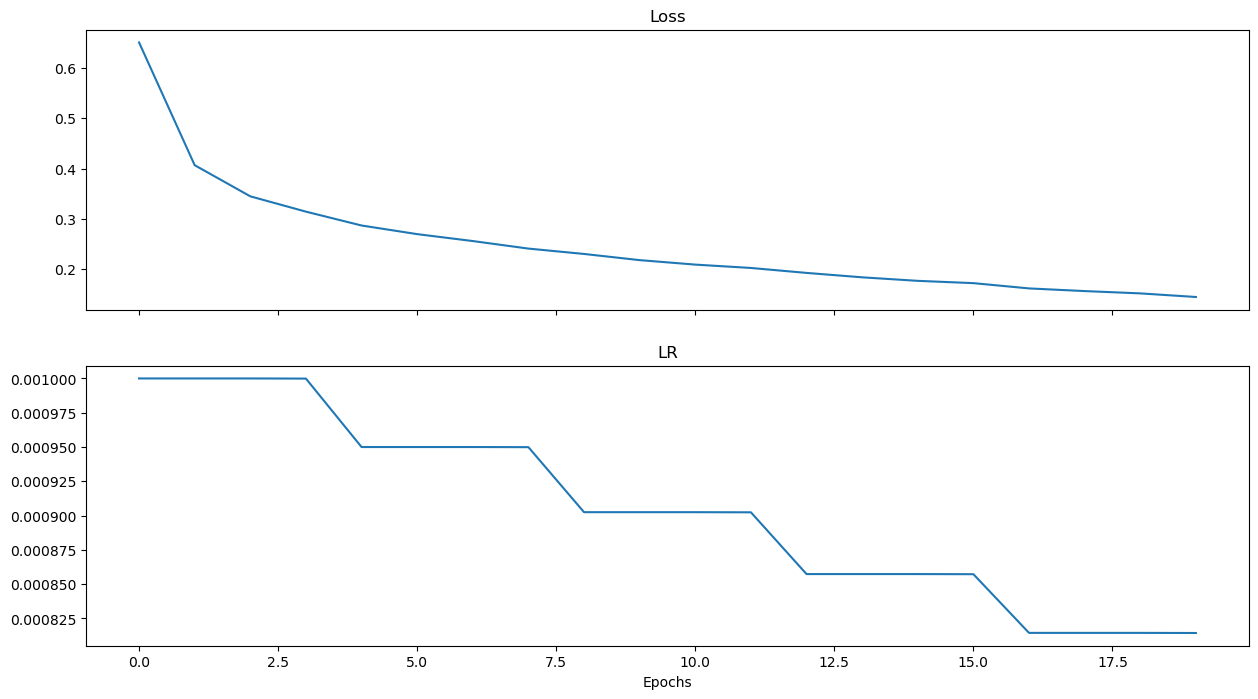

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
ax1.plot(epoch_losses)
ax1.set_title('Loss')
ax2.plot(epoch_lrs)
ax2.set_title('LR')
plt.xlabel('Epochs')
plt.show()

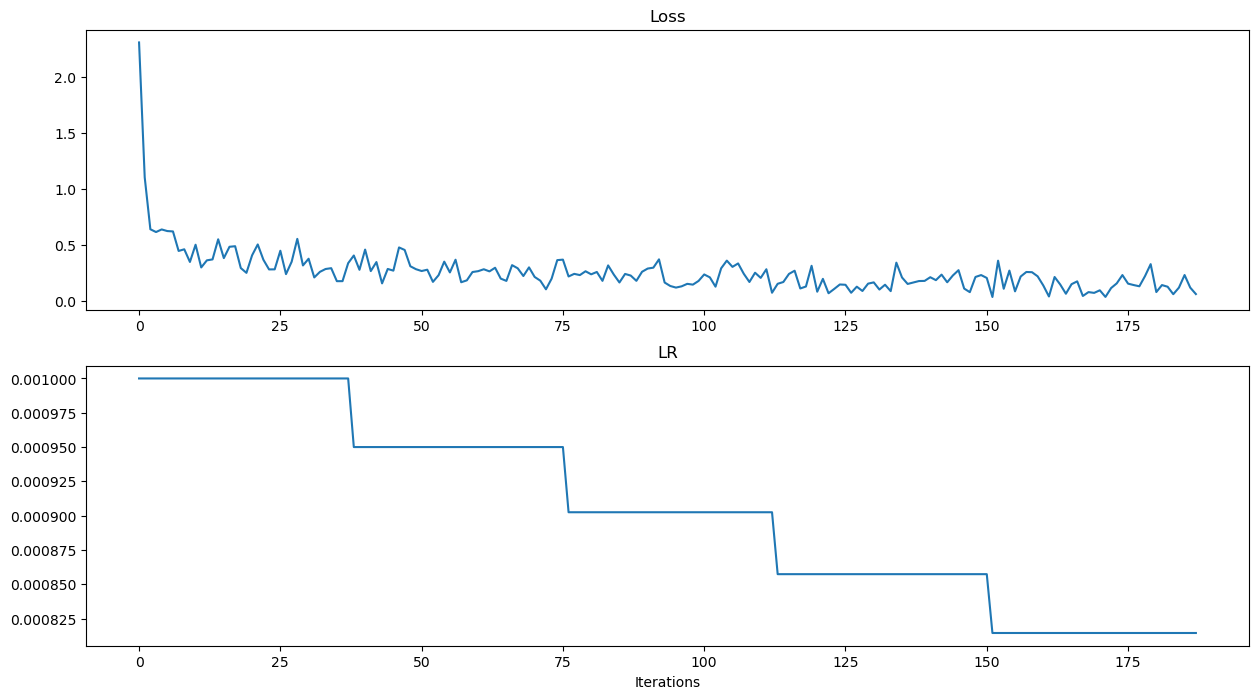

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))
ax1.plot(iteration_losses[::100])
ax1.set_title('Loss')
ax2.plot(iteration_lrs[::100])
ax2.set_title('LR')
plt.xlabel('Iterations')
plt.show()

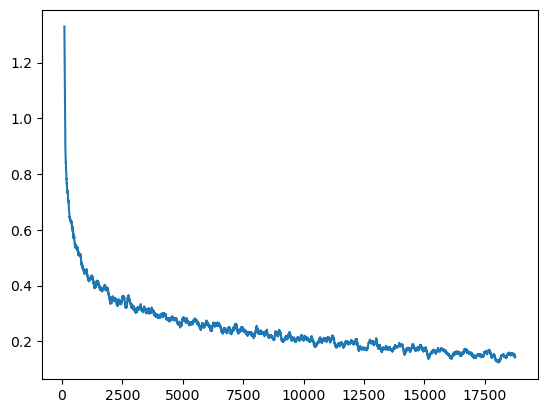

In [28]:
window = 100 
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

In [30]:
path = os.path.join("storage", "models", "fashion-mnist", "classifier.pth")
torch.save(model.state_dict(), path)

# 9.Test Model

In [31]:
path = os.path.join("storage", "models", "fashion-mnist", "classifier.pth")
model = Model()
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [32]:
for p in model.parameters():
    print(p.is_cuda)

True
True
True
True
True
True
True
True
True
True


In [34]:
with torch.no_grad():
    Y_train, Y_pred_train = [], []
    for X_mb, Y_mb in tqdm(train_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_train.extend(Y_mb.numpy().tolist())
        Y_pred_train.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/938 [00:00<?, ?it/s]

In [35]:
with torch.no_grad():
    Y_test, Y_pred_test = [], []
    for X_mb, Y_mb in tqdm(test_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_test.extend(Y_mb.numpy().tolist())
        Y_pred_test.extend(Y_pred_mb.cpu().numpy().tolist())

  0%|          | 0/2500 [00:00<?, ?it/s]

In [36]:
train_accuracy = accuracy_score(Y_train, Y_pred_train)
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train Accuracy: 0.95245
Test Accuracy: 0.9063


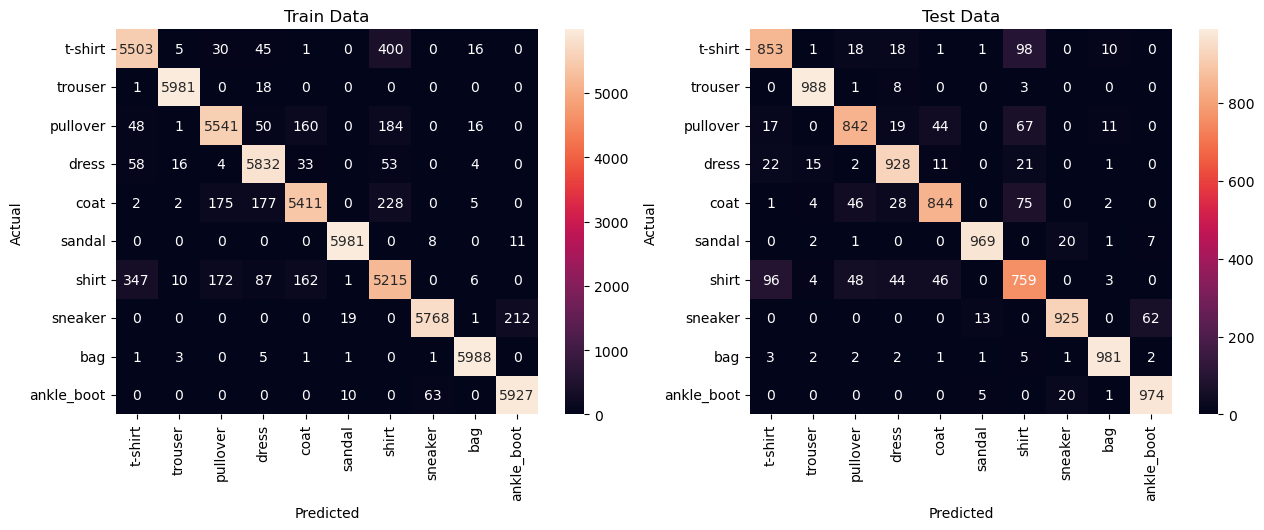

In [37]:
labels = [label_to_name[str(i)] for i in range(10)]
c_mat_train = confusion_matrix(Y_train, Y_pred_train)
c_mat_test = confusion_matrix(Y_test, Y_pred_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(c_mat_train, annot=True, fmt='d', ax=ax1, xticklabels=labels, yticklabels=labels)
ax1.set_title('Train Data')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
sns.heatmap(c_mat_test, annot=True, fmt='d', ax=ax2, xticklabels=labels, yticklabels=labels)
ax2.set_title('Test Data')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
plt.show()

In [38]:
def compute_accuracies(c_mat):
    accuracies = c_mat.astype('float') / c_mat.sum(axis=1)
    accuracies = accuracies.diagonal()
    accuracies = {k:v for k,v in zip(labels,accuracies)}
    return accuracies

In [40]:
compute_accuracies(c_mat_train)

{'t-shirt': 0.9171666666666667,
 'trouser': 0.9968333333333333,
 'pullover': 0.9235,
 'dress': 0.972,
 'coat': 0.9018333333333334,
 'sandal': 0.9968333333333333,
 'shirt': 0.8691666666666666,
 'sneaker': 0.9613333333333334,
 'bag': 0.998,
 'ankle_boot': 0.9878333333333333}

In [41]:
compute_accuracies(c_mat_test)

{'t-shirt': 0.853,
 'trouser': 0.988,
 'pullover': 0.842,
 'dress': 0.928,
 'coat': 0.844,
 'sandal': 0.969,
 'shirt': 0.759,
 'sneaker': 0.925,
 'bag': 0.981,
 'ankle_boot': 0.974}